# Energy Consumption Forecasting
## Table of Contents
1. [Model Selection](#model-selection)
2. [Feature Engineering](#feature-engineering)
3. [Hyperparameter Tuning](#hyperparameter-tuning)
4. [Implementation](#implementation)



In [3]:
# Import data from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [97]:
import pandas as pd
import numpy as np
import holidays
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from math import sqrt
from tensorflow.keras.regularizers import l1, l2
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf


## Model Selection

Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU) are two types of Recurrent Neural Networks (RNNs) that are widely used for sequence prediction tasks, including electricity consumption prediction.

* LSTM (Long Short-Term Memory) are designed to overcome the vanishing gradient problem of traditional RNNs by incorporating memory cells that can maintain information over long sequences. LSTMs are excellent at capturing temporal dependencies and patterns within time-series data, making them suitable for predicting future values based on past consumption. LSTMs can model complex nonlinear relationships in electricity usage patterns, accounting for factors like time of day, temperature, and seasonal variations.
* GRU (Gated Recurrent Unit)
GRUs are a variation of LSTMs with a simpler structure. GRUs have fewer parameters than LSTMs, which can lead to faster training times and reduced computational complexity.



## Feature Engineering

* The electricity Consumption is multilevel seasonality.  
  * month $(M_i)$, where $i$ = 1 (Jan.), 2 (Feb.), ..., 11 (Nov.), 0 (Dec.)
  * week $(W_j)$, where $j$ = 1 (Mon),..., 6 (Sat), 0 (Sun)
  * Hours of Daylight ($HDL_t$)
  * Holidays ($H_t$)
  * Temperature ($T_t$)

In [5]:
# Load the dataset
energy_data = pd.read_csv("drive/MyDrive/data/energy.csv", parse_dates=['Date (UTC)'], index_col='Date (UTC)')

# Feature Engineering
# dummy variables for month and week
energy_data['Month'] = energy_data.index.month
month_dummies = pd.get_dummies(energy_data['Month'], prefix='Month')
energy_data = pd.concat([energy_data, month_dummies], axis=1)

energy_data['Week'] = energy_data.index.weekday
week_dummies = pd.get_dummies(energy_data['Week'], prefix='Week')
energy_data = pd.concat([energy_data, week_dummies], axis=1)

# HDL (Hours of Daylight)
energy_data['d_t'] = energy_data.index.dayofyear
# Sun's inclination angle (lambda_t) calculation
lambda_t = 0.4102 * np.sin((2 * np.pi / 365) * (energy_data['d_t'] - 80.25))
# Latitude for Germany
delta = 52
HDL = 7.722 * np.arccos(-np.tan(2 * np.pi * delta / 360) * np.tan(lambda_t))
energy_data['HDL'] = HDL

# dummy variables for holidays
H = holidays.Germany()
# Function to check if a date is a holiday
def is_holiday(date):
    return date in H

energy_data['holiday'] = energy_data.index.to_series().apply(is_holiday)
energy_data['holiday'] = energy_data['holiday'].astype(int)

# select dataset for train model
start_date = '2018-03-01'
end_date = '2019-03-01'
filtered_data = energy_data[(energy_data.index >= start_date) & (energy_data.index <= end_date)]
filtered_data = filtered_data.drop(['Month', 'Week', 'd_t'], axis=1)
features_to_scale = ['Load', 'Temperature', 'HDL']
# Initialize the scaler
scaler = MinMaxScaler()
# Scale the features
filtered_data[features_to_scale] = scaler.fit_transform(filtered_data[features_to_scale])
filtered_data.head()

Load  Temperature  Month_1  Month_2  Month_3  \
Date (UTC)                                                                    
2018-03-01 00:00:00+00:00  0.622910     0.011655        0        0        1   
2018-03-01 01:00:00+00:00  0.592432     0.009324        0        0        1   
2018-03-01 02:00:00+00:00  0.581618     0.006993        0        0        1   
2018-03-01 03:00:00+00:00  0.601302     0.004662        0        0        1   
2018-03-01 04:00:00+00:00  0.665726     0.002331        0        0        1   

                           Month_4  Month_5  Month_6  Month_7  Month_8  ...  \
Date (UTC)                                                              ...   
2018-03-01 00:00:00+00:00        0        0        0        0        0  ...   
2018-03-01 01:00:00+00:00        0        0        0        0        0  ...   
2018-03-01 02:00:00+00:00        0        0        0        0        0  ...   
2018-03-01 03:00:00+00:00        0        0        0        0        0  ...   
2018-03-01 04:00:00+00:00        0        0        0        0        0  ...   

                           Month_12  Week_0  Week_1  Week_2  Week_3  Week_4  \
Date (UTC)                                                                    
2018-03-01 00:00:00+00:00         0       0       0       0       1       0   
2018-03-01 01:00:00+00:00         0       0       0       0       1       0   
2018-03-01 02:00:00+00:00         0       0       0       0       1       0   
2018-03-01 03:00:00+00:00         0       0       0       0       1       0   
2018-03-01 04:00:00+00:00         0       0       0       0       1       0   

                           Week_5  Week_6      HDL  holiday  
Date (UTC)                                                   
2018-03-01 00:00:00+00:00       0       0  0.34626        0  
2018-03-01 01:00:00+00:00       0       0  0.34626        0  
2018-03-01 02:00:00+00:00       0       0  0.34626        0  
2018-03-01 03:00:00+00:00       0       0  0.34626        0  
2018-03-01 04:00:00+00:00       0       0  0.34626        0  

[5 rows x 23 columns]

* Group 1: Feature (Load)
* Group 2: Feature (Load, Temperature)
* Group 3: Feature (Load, Temperature, HDL)
* Group 4: Feature (Load, Temperature, HDL, holiday)
* Group 5: Feature (Load, Temperature, HDL, holiday, month, week)
### One Houe Forecasting

In [26]:
# Reshape data for LSTM and GRU
def create_dataset(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        # Extract the sequence from the dataset
        seq_x = data.iloc[i:(i + n_steps)].values  # Convert to numpy array
        # Append the sequence to X
        X.append(seq_x)
        # Append the target (next value) to y
        # Assuming the target is the first column
        y.append(data.iloc[i + n_steps, 0])
    return np.array(X), np.array(y)

# set LSTM and GRU model for training
def create_model_h(model_type, input_shape, hidden_units=50, dense_units=1, activation='linear'):
    """
    Creates and returns a Sequential model with either an LSTM or GRU layer.

    Parameters:
    model_type (str): Type of the model - 'LSTM' or 'GRU'.
    input_shape (tuple): Shape of the input data (time steps, features).
    hidden_units (int): Number of units in the LSTM/GRU layer.
    dense_units (int): Number of units in the Dense output layer.
    activation (str): 'linear' is a common choice for regression problems.

    Returns:
    Sequential model
    """
    model = Sequential()

    if model_type == 'LSTM':
        model.add(LSTM(hidden_units, input_shape=input_shape))
    elif model_type == 'GRU':
        model.add(GRU(hidden_units, input_shape=input_shape))

    model.add(Dense(dense_units, activation=activation))

    return model

In [7]:
filtered_data_1 = filtered_data[['Load']]
filtered_data_2 = filtered_data[['Load', 'Temperature']]
filtered_data_3 = filtered_data[['Load', 'Temperature', 'HDL']]
filtered_data_4 = filtered_data[['Load', 'Temperature', 'HDL', 'holiday']]

In [27]:
n_steps = 7
n_features = 1
X, y = create_dataset(filtered_data_1, n_steps)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM
model_LSTM = create_model_h('LSTM', input_shape = (n_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)
history_LSTM = model_LSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# GRU
model_GRU = create_model_h('GRU', input_shape = (n_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_GRU.compile(loss='mean_squared_error', optimizer=optimizer)
history_GRU = model_GRU.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# Evaluate
X_val, y_val = X_train[int(X_train.shape[0]*0.8):], y_train[int(y_train.shape[0]*0.8):]
lstm_eval = model_LSTM.evaluate(X_val, y_val, verbose=0)
gru_eval = model_GRU.evaluate(X_val, y_val, verbose=0)
lstm_eval, gru_eval

(0.001430673524737358, 0.00103258085437119)

In [28]:
n_steps = 7
n_features = 2
X, y = create_dataset(filtered_data_2, n_steps)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM
model_LSTM = create_model_h('LSTM', input_shape = (n_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)
history_LSTM = model_LSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# GRU
model_GRU = create_model_h('GRU', input_shape = (n_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_GRU.compile(loss='mean_squared_error', optimizer=optimizer)
history_GRU = model_GRU.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# Evaluate
X_val, y_val = X_train[int(X_train.shape[0]*0.8):], y_train[int(y_train.shape[0]*0.8):]
lstm_eval = model_LSTM.evaluate(X_val, y_val, verbose=0)
gru_eval = model_GRU.evaluate(X_val, y_val, verbose=0)
lstm_eval, gru_eval

(0.0008306069066748023, 0.001639542169868946)

In [29]:
n_steps = 7
n_features = 3
filtered_data_3 = filtered_data[['Load', 'Temperature', 'HDL']]
X, y = create_dataset(filtered_data_3, n_steps)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM
model_LSTM = create_model_h('LSTM', input_shape = (n_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)
history_LSTM = model_LSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# GRU
model_GRU = create_model_h('GRU', input_shape = (n_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_GRU.compile(loss='mean_squared_error', optimizer=optimizer)
history_GRU = model_GRU.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# Evaluate
X_val, y_val = X_train[int(X_train.shape[0]*0.8):], y_train[int(y_train.shape[0]*0.8):]
lstm_eval = model_LSTM.evaluate(X_val, y_val, verbose=0)
gru_eval = model_GRU.evaluate(X_val, y_val, verbose=0)
lstm_eval, gru_eval

(0.0005190868396311998, 0.0006672508898191154)

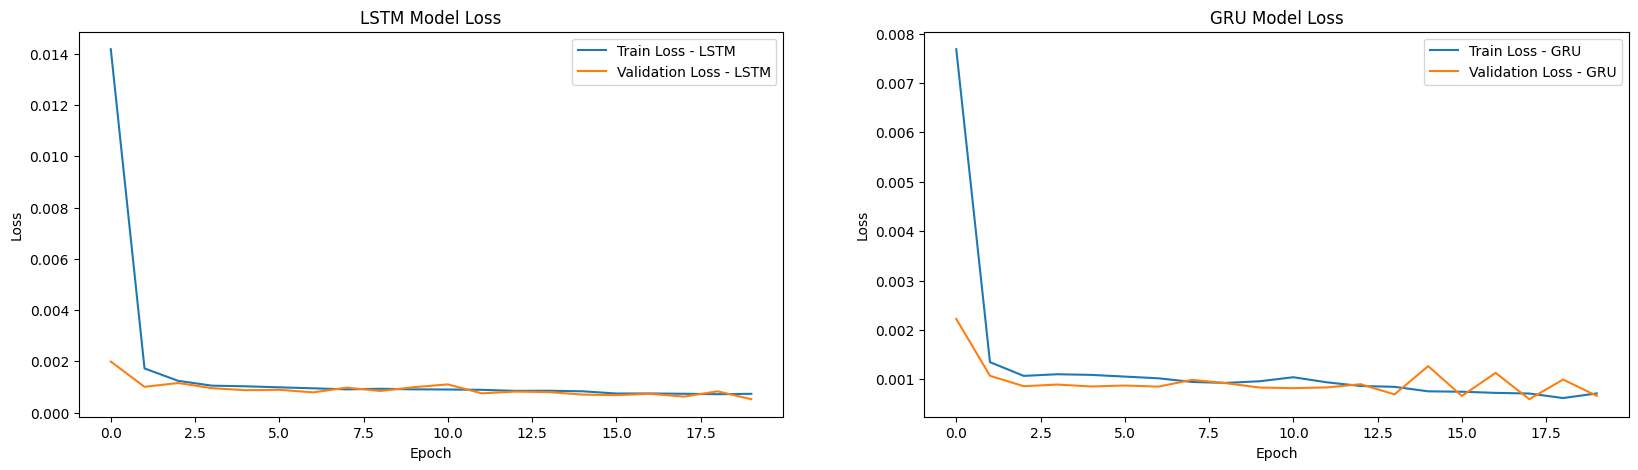

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# LSTM Loss Plot
axes[0].plot(history_LSTM.history['loss'], label='Train Loss - LSTM')
axes[0].plot(history_LSTM.history['val_loss'], label='Validation Loss - LSTM')
axes[0].set_title('LSTM Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(loc='upper right')

# GRU Loss Plot
axes[1].plot(history_GRU.history['loss'], label='Train Loss - GRU')
axes[1].plot(history_GRU.history['val_loss'], label='Validation Loss - GRU')
axes[1].set_title('GRU Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')

plt.show()

* LSTM Model Loss

The validation loss decreases alongside the training loss, suggesting that the model is generalizing well and not overfitting significantly. The validation loss remains relatively flat after the initial drop, which is a good sign that the model's performance is stable across both the training and validation datasets.
* GRU Model Loss

The validation loss decreases initially but then shows some volatility, with several peaks and troughs. It's not as stable as the LSTM's validation loss, which may suggest some degree of overfitting or that the model is not learning as consistently from the validation data. However, the validation loss does seem to trend downward overall, which is positive.
* Early Stopping: Implementing early stopping could be beneficial, especially for the GRU model, to prevent overfitting and to stop training when the validation loss no longer improves.
* Hyperparameter Tuning: Adjusting the models' hyperparameters, such as learning rate, hidden units, could potentially improve performance.

In [31]:
n_steps = 7
n_features = 4
X, y = create_dataset(filtered_data_4, n_steps)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM
model_LSTM = create_model_h('LSTM', input_shape = (n_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)
history_LSTM = model_LSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# GRU
model_GRU = create_model_h('GRU', input_shape = (n_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_GRU.compile(loss='mean_squared_error', optimizer=optimizer)
history_GRU = model_GRU.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# Evaluate
X_val, y_val = X_train[int(X_train.shape[0]*0.8):], y_train[int(y_train.shape[0]*0.8):]
lstm_eval = model_LSTM.evaluate(X_val, y_val, verbose=0)
gru_eval = model_GRU.evaluate(X_val, y_val, verbose=0)
lstm_eval, gru_eval

(0.000604911707341671, 0.001141896122135222)

In [32]:
n_steps = 7
n_features = 23
X, y = create_dataset(filtered_data, n_steps)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM
model_LSTM = create_model_h('LSTM', input_shape = (n_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)
history_LSTM = model_LSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# GRU
model_GRU = create_model_h('GRU', input_shape = (n_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_GRU.compile(loss='mean_squared_error', optimizer=optimizer)
history_GRU = model_GRU.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# Evaluate
X_val, y_val = X_train[int(X_train.shape[0]*0.8):], y_train[int(y_train.shape[0]*0.8):]
lstm_eval = model_LSTM.evaluate(X_val, y_val, verbose=0)
gru_eval = model_GRU.evaluate(X_val, y_val, verbose=0)
lstm_eval, gru_eval

(0.0006294975173659623, 0.0012038504937663674)

| Group | 1     | 2     | 3     | 4     | 5     |
|-------|-------|-------|-------|-------|-------|
| LSTM  | 0.0378    |   0.0288    |  0.0228     |   0.0246    |  0.0251     |
|       |       |       |       |       |       |
|  GRU  | 0.0321    |    0.0405   |   0.0258    |     0.0338  |   0.0347    |


* Model Complexity and Feature Handling

The LSTM model consistently performs better as the number of features increases, which might be due to its ability to handle complexity more effectively than the GRU model. GRU's Efficiency in Simpler Tasks: In the simplest feature set (Group 1), the GRU model outperforms LSTM, possibly due to its simpler and more efficient structure, which can be advantageous in less complex tasks.
* Feature Impact

he addition of features generally improves the performance of the LSTM model, indicating the importance of feature engineering in time series forecasting. Increasing the number of features introduces more complexity and potentially more noise into the models. This might be why the MSE increases for both models in the Group 4 and Group 5 scenario.
More features do not always lead to better performance, especially if some of the added features do not have a strong predictive relationship with the target variable or are highly correlated with each other.
* For one houe forecasting, month, week and holiday dummy variables do not have a strong predictive relationship with electricity consumption.


### One Day Forecasting

In [19]:
def create_sequences(data, n_input_steps, n_output_steps):
    X, y = [], []
    for i in range(len(data) - n_input_steps - n_output_steps + 1):
        seq_x = data.iloc[i:(i + n_input_steps)].values
        seq_y = data.iloc[i + n_input_steps:i + n_input_steps + n_output_steps, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

def create_model_d(model_type, input_shape, hidden_units=50, dense_units=24, activation='linear'):
    model = Sequential()

    if model_type == 'LSTM':
        model.add(LSTM(hidden_units, input_shape=input_shape))
    elif model_type == 'GRU':
        model.add(GRU(hidden_units, input_shape=input_shape))

    model.add(Dense(dense_units, activation=activation))

    return model

In [41]:
n_input_steps = 24
n_output_steps = 24
n_features = 1
X, y = create_sequences(filtered_data_1, n_input_steps, n_output_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM
model_LSTM = create_model_d('LSTM', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_LSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# GRU
model_GRU = create_model_d('GRU', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_GRU.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_GRU.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# Evaluate
X_val, y_val = X_train[int(X_train.shape[0]*0.8):], y_train[int(y_train.shape[0]*0.8):]
lstm_eval = model_LSTM.evaluate(X_val, y_val, verbose=0)
gru_eval = model_GRU.evaluate(X_val, y_val, verbose=0)
lstm_eval, gru_eval

(0.009310271590948105, 0.011032422073185444)

In [21]:
n_input_steps = 24
n_output_steps = 24
n_features = 2
X, y = create_sequences(filtered_data_2, n_input_steps, n_output_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM
model_LSTM = create_model_d('LSTM', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_LSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# GRU
model_GRU = create_model_d('GRU', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_GRU.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_GRU.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# Evaluate
X_val, y_val = X_train[int(X_train.shape[0]*0.8):], y_train[int(y_train.shape[0]*0.8):]
lstm_eval = model_LSTM.evaluate(X_val, y_val, verbose=0)
gru_eval = model_GRU.evaluate(X_val, y_val, verbose=0)
lstm_eval, gru_eval

(0.009156194515526295, 0.009912274777889252)

In [22]:
n_input_steps = 24
n_output_steps = 24
n_features = 3
X, y = create_sequences(filtered_data_3, n_input_steps, n_output_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM
model_LSTM = create_model_d('LSTM', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_LSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# GRU
model_GRU = create_model_d('GRU', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_GRU.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_GRU.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# Evaluate
X_val, y_val = X_train[int(X_train.shape[0]*0.8):], y_train[int(y_train.shape[0]*0.8):]
lstm_eval = model_LSTM.evaluate(X_val, y_val, verbose=0)
gru_eval = model_GRU.evaluate(X_val, y_val, verbose=0)
lstm_eval, gru_eval

(0.008147775195538998, 0.010648488067090511)

In [23]:
n_input_steps = 24
n_output_steps = 24
n_features = 4
filtered_data_4 = filtered_data[['Load', 'Temperature', 'HDL', 'holiday']]
X, y = create_sequences(filtered_data_4, n_input_steps, n_output_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM
model_LSTM = create_model_d('LSTM', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_LSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# GRU
model_GRU = create_model_d('GRU', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_GRU.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_GRU.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# Evaluate
X_val, y_val = X_train[int(X_train.shape[0]*0.8):], y_train[int(y_train.shape[0]*0.8):]
lstm_eval = model_LSTM.evaluate(X_val, y_val, verbose=0)
gru_eval = model_GRU.evaluate(X_val, y_val, verbose=0)
lstm_eval, gru_eval

(0.007762202061712742, 0.009785930626094341)

In [24]:
n_input_steps = 24
n_output_steps = 24
n_features = 23
X, y = create_sequences(filtered_data, n_input_steps, n_output_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM
model_LSTM = create_model_d('LSTM', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_LSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# GRU
model_GRU = create_model_d('GRU', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_GRU.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_GRU.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# Evaluate
X_val, y_val = X_train[int(X_train.shape[0]*0.8):], y_train[int(y_train.shape[0]*0.8):]
lstm_eval = model_LSTM.evaluate(X_val, y_val, verbose=0)
gru_eval = model_GRU.evaluate(X_val, y_val, verbose=0)
lstm_eval, gru_eval

(0.0024977100547403097, 0.0027733170427381992)

| Group | 1     | 2     | 3     | 4     | 5     |
|-------|-------|-------|-------|-------|-------|
| LSTM  | 0.0965| 0.0957|0.0903 |0.0881 |0.0450 |
|       |       |       |       |       |       |
|  GRU  |0.1050 | 0.0996|0.1032 |0.0989 |0.0527 |


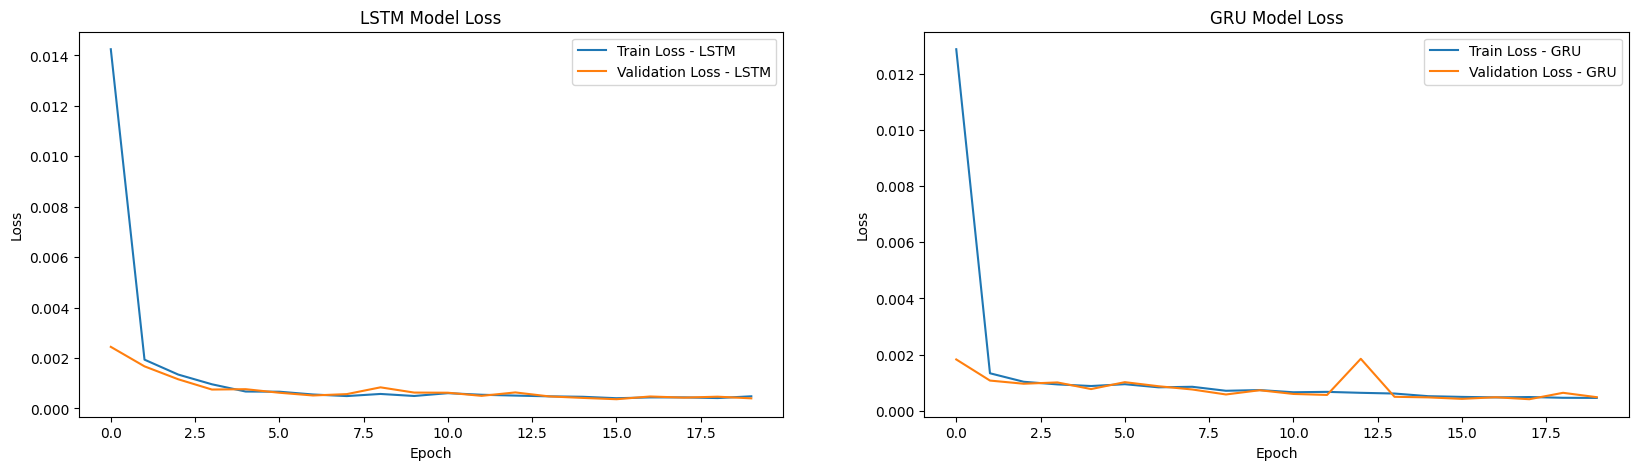

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# LSTM Loss Plot
axes[0].plot(history_LSTM.history['loss'], label='Train Loss - LSTM')
axes[0].plot(history_LSTM.history['val_loss'], label='Validation Loss - LSTM')
axes[0].set_title('LSTM Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(loc='upper right')

# GRU Loss Plot
axes[1].plot(history_GRU.history['loss'], label='Train Loss - GRU')
axes[1].plot(history_GRU.history['val_loss'], label='Validation Loss - GRU')
axes[1].set_title('GRU Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')

plt.show()

* For one day forecasting, including all features lead to better performance.
* The GRU validation loss decreases but fluctuates later, so that we can reduce the learning rate in the later part

### One Week Forecasting

In [46]:
def create_model_w(model_type, input_shape, hidden_units=50, dense_units=168, activation='linear'):
    model = Sequential()

    if model_type == 'LSTM':
        model.add(LSTM(hidden_units, input_shape=input_shape))
    elif model_type == 'GRU':
        model.add(GRU(hidden_units, input_shape=input_shape))

    model.add(Dense(dense_units, activation=activation))

    return model

In [47]:
n_input_steps = 24
n_output_steps = 168
n_features = 1
X, y = create_sequences(filtered_data_1, n_input_steps, n_output_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM
model_LSTM = create_model_w('LSTM', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_LSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# GRU
model_GRU = create_model_w('GRU', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_GRU.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_GRU.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# Evaluate
X_val, y_val = X_train[int(X_train.shape[0]*0.8):], y_train[int(y_train.shape[0]*0.8):]
lstm_eval = model_LSTM.evaluate(X_val, y_val, verbose=0)
gru_eval = model_GRU.evaluate(X_val, y_val, verbose=0)
lstm_eval, gru_eval

(0.017964955419301987, 0.018529199063777924)

In [48]:
n_input_steps = 24
n_output_steps = 168
n_features = 2
X, y = create_sequences(filtered_data_2, n_input_steps, n_output_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM
model_LSTM = create_model_w('LSTM', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_LSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# GRU
model_GRU = create_model_w('GRU', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_GRU.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_GRU.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# Evaluate
X_val, y_val = X_train[int(X_train.shape[0]*0.8):], y_train[int(y_train.shape[0]*0.8):]
lstm_eval = model_LSTM.evaluate(X_val, y_val, verbose=0)
gru_eval = model_GRU.evaluate(X_val, y_val, verbose=0)
lstm_eval, gru_eval

(0.017813963815569878, 0.01833992265164852)

In [49]:
n_input_steps = 24
n_output_steps = 168
n_features = 3
X, y = create_sequences(filtered_data_3, n_input_steps, n_output_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM
model_LSTM = create_model_w('LSTM', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_LSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# GRU
model_GRU = create_model_w('GRU', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_GRU.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_GRU.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# Evaluate
X_val, y_val = X_train[int(X_train.shape[0]*0.8):], y_train[int(y_train.shape[0]*0.8):]
lstm_eval = model_LSTM.evaluate(X_val, y_val, verbose=0)
gru_eval = model_GRU.evaluate(X_val, y_val, verbose=0)
lstm_eval, gru_eval

(0.016398657113313675, 0.01705353334546089)

In [50]:
n_input_steps = 24
n_output_steps = 168
n_features = 4
X, y = create_sequences(filtered_data_4, n_input_steps, n_output_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM
model_LSTM = create_model_w('LSTM', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_LSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# GRU
model_GRU = create_model_w('GRU', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_GRU.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_GRU.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# Evaluate
X_val, y_val = X_train[int(X_train.shape[0]*0.8):], y_train[int(y_train.shape[0]*0.8):]
lstm_eval = model_LSTM.evaluate(X_val, y_val, verbose=0)
gru_eval = model_GRU.evaluate(X_val, y_val, verbose=0)
lstm_eval, gru_eval

(0.01606689766049385, 0.016677211970090866)

In [51]:
n_input_steps = 24
n_output_steps = 168
n_features = 23
X, y = create_sequences(filtered_data, n_input_steps, n_output_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM
model_LSTM = create_model_w('LSTM', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_LSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# GRU
model_GRU = create_model_w('GRU', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_GRU.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_GRU.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# Evaluate
X_val, y_val = X_train[int(X_train.shape[0]*0.8):], y_train[int(y_train.shape[0]*0.8):]
lstm_eval = model_LSTM.evaluate(X_val, y_val, verbose=0)
gru_eval = model_GRU.evaluate(X_val, y_val, verbose=0)
lstm_eval, gru_eval

(0.0054010748863220215, 0.005586741957813501)

| Group | 1     | 2     | 3     | 4     | 5     |
|-------|-------|-------|-------|-------|-------|
| LSTM  |0.1340 |0.1335 |0.1281 |0.1268 |0.0735 |
|       |       |       |       |       |       |
|  GRU  |0.1361 |0.1354 |0.1306 |0.1291 |0.0747 |

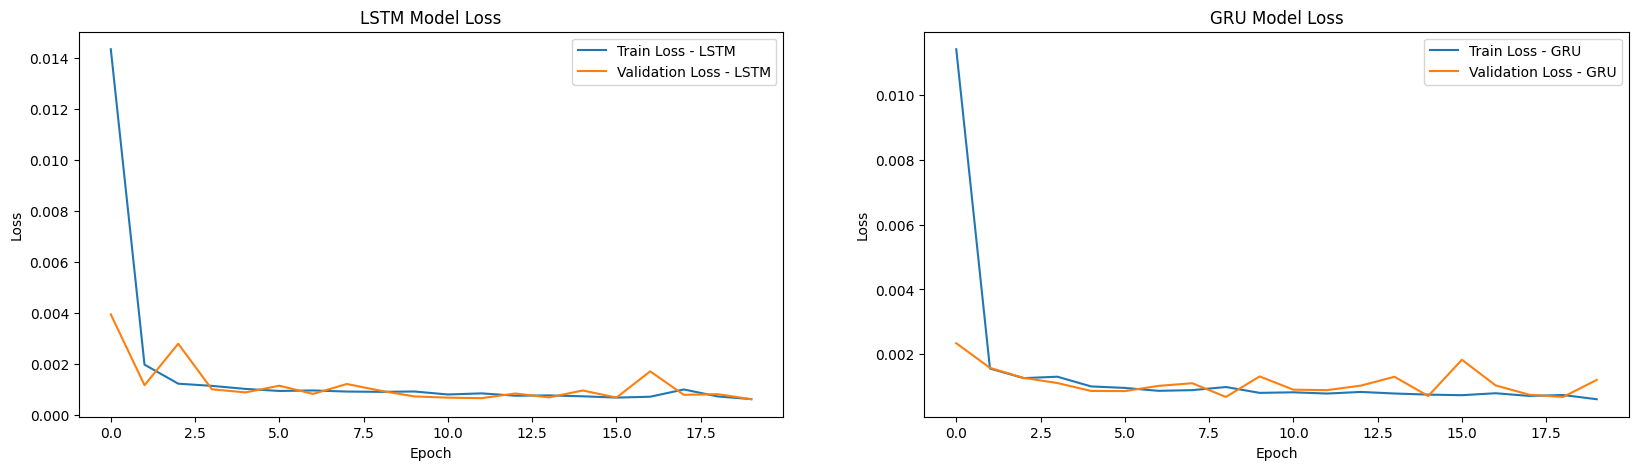

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# LSTM Loss Plot
axes[0].plot(history_LSTM.history['loss'], label='Train Loss - LSTM')
axes[0].plot(history_LSTM.history['val_loss'], label='Validation Loss - LSTM')
axes[0].set_title('LSTM Model Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(loc='upper right')

# GRU Loss Plot
axes[1].plot(history_GRU.history['loss'], label='Train Loss - GRU')
axes[1].plot(history_GRU.history['val_loss'], label='Validation Loss - GRU')
axes[1].set_title('GRU Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')

plt.show()

Both models learn most of the patterns within the first few epochs, after which the rate of improvement in loss reduction slows down.
* Overfitting Signs

The volatility in the validation loss, especially for the GRU model, indicates that the model might benefit from techniques to reduce overfitting, such as introducing dropout, regularization, or implementing early stopping.
* Learning Rate

Given the sharp initial decrease in loss, the learning rate seems to be adequately high for initial convergence. However, if overfitting is a concern, reducing the learning rate could help. Alternatively, a learning rate schedule that decreases the learning rate over time might stabilize the learning process and help with generalization.

## Hyperparameter Tuning

Here we adjust models in two methods: n_steps and learning rate
* n_steps

n_steps refers to the number of previous time steps of data that the model uses to make a prediction. It defines the size of the input sequence window for the LSTM or GRU. A larger n_steps value allows the model to learn from longer sequences, which can be beneficial for capturing long-term dependencies in the data.
* Learning Rate

The learning rate is a hyperparameter that determines the size of the steps the model takes during the optimization process. It influences how quickly the model learns. Modern optimization algorithms like Adam adjust the learning rate during training, which can help mitigate the risks of choosing an inappropriate static learning rate.

Here, we consider using learning rate decay or cyclical learning rates to dynamically adjust the learning rate during training, which can lead to better convergence properties.



In [84]:
# Initial learning rate
initial_learning_rate = 0.01
# Decay rate and step
decay_steps = 10 * (len(X_train) / 32)
decay_rate = 0.1
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps, decay_rate, staircase=True)

### One Hour Forecasting


In [66]:
n_steps = 48
n_features = 3
X, y = create_dataset(filtered_data_3, n_steps)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM
model_LSTM = create_model_h('LSTM', input_shape = (n_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)
history_LSTM = model_LSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# GRU
model_GRU = create_model_h('GRU', input_shape = (n_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_GRU.compile(loss='mean_squared_error', optimizer=optimizer)
history_GRU = model_GRU.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# Evaluate
X_val, y_val = X_train[int(X_train.shape[0]*0.8):], y_train[int(y_train.shape[0]*0.8):]
lstm_eval = model_LSTM.evaluate(X_val, y_val, verbose=0)
gru_eval = model_GRU.evaluate(X_val, y_val, verbose=0)
lstm_eval, gru_eval

(0.00028939597541466355, 0.0006518826703540981)

In [57]:
n_steps = 24
n_features = 3
X, y = create_dataset(filtered_data_3, n_steps)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM
model_LSTM = create_model_h('LSTM', input_shape = (n_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)
history_LSTM = model_LSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# GRU
model_GRU = create_model_h('GRU', input_shape = (n_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_GRU.compile(loss='mean_squared_error', optimizer=optimizer)
history_GRU = model_GRU.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# Evaluate
X_val, y_val = X_train[int(X_train.shape[0]*0.8):], y_train[int(y_train.shape[0]*0.8):]
lstm_eval = model_LSTM.evaluate(X_val, y_val, verbose=0)
gru_eval = model_GRU.evaluate(X_val, y_val, verbose=0)
lstm_eval, gru_eval

(0.0005230215610936284, 0.0004021503555122763)

In [58]:
n_steps = 72
n_features = 3
X, y = create_dataset(filtered_data_3, n_steps)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM
model_LSTM = create_model_h('LSTM', input_shape = (n_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)
history_LSTM = model_LSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# GRU
model_GRU = create_model_h('GRU', input_shape = (n_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_GRU.compile(loss='mean_squared_error', optimizer=optimizer)
history_GRU = model_GRU.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# Evaluate
X_val, y_val = X_train[int(X_train.shape[0]*0.8):], y_train[int(y_train.shape[0]*0.8):]
lstm_eval = model_LSTM.evaluate(X_val, y_val, verbose=0)
gru_eval = model_GRU.evaluate(X_val, y_val, verbose=0)
lstm_eval, gru_eval

(0.00036367232678458095, 0.0003352742933202535)

|n_steps| 24    | 48    | 72    |
|-------|-------|-------|-------|
| LSTM  |0.0229 |0.0169 |0.0191 |
|       |       |       |       |
|  GRU  |0.0201 |0.0220 |0.0183 |

* Optimal Sequence Length

There seems to be an optimal sequence length for each model where the forecasting performance is maximized (48 steps for LSTM and 72 steps for GRU in your case).
* Model Characteristics

GRUs might be more efficient with smaller datasets or shorter sequences, while LSTMs may excel with a moderate amount of past information but may not benefit as much from even longer sequences for this specific task.
* Complexity vs. Performance

A balance between the complexity of the model (in terms of the information it can process) and the performance needs to be struck. More data (higher n_steps) doesn't always lead to better performance, as seen with the 72 steps for LSTM.

In [64]:
n_steps = 48
n_features = 3
X, y = create_dataset(filtered_data_3, n_steps)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM
model_LSTM = create_model_h('LSTM', input_shape = (n_steps, n_features))
optimizer = Adam(learning_rate=lr_schedule)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)
history_LSTM = model_LSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# GRU
model_GRU = create_model_h('GRU', input_shape = (n_steps, n_features))
optimizer = Adam(learning_rate=lr_schedule)
model_GRU.compile(loss='mean_squared_error', optimizer=optimizer)
history_GRU = model_GRU.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# Evaluate
X_val, y_val = X_train[int(X_train.shape[0]*0.8):], y_train[int(y_train.shape[0]*0.8):]
lstm_eval = model_LSTM.evaluate(X_val, y_val, verbose=0)
gru_eval = model_GRU.evaluate(X_val, y_val, verbose=0)
lstm_eval, gru_eval

(0.0004956154152750969, 0.0005199629231356084)

44/44 [==============================] - 1s 7ms/step


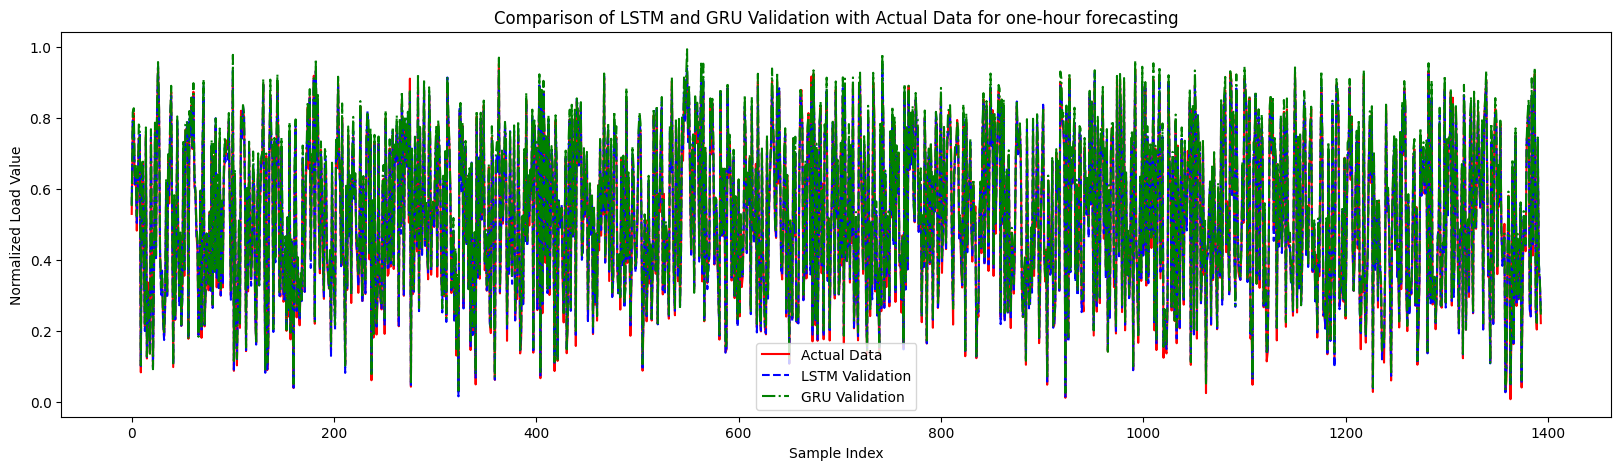

In [67]:
lstm_validation = model_LSTM.predict(X_val)
gru_validation = model_GRU.predict(X_val)

# Plotting
plt.figure(figsize=(20, 5))
plt.plot(y_val, label='Actual Data', color='red', linestyle='-')
plt.plot(lstm_validation, label='LSTM Validation', color='blue', linestyle='--')
plt.plot(gru_validation, label='GRU Validation', color='green', linestyle='-.')
plt.title('Comparison of LSTM and GRU Validation with Actual Data for one-hour forecasting')
plt.xlabel('Sample Index')
plt.ylabel('Normalized Load Value')
plt.legend()
plt.show()

* Improved Performance with Learning Rate Decay

In both models (LSTM and GRU), implementing an exponential decay learning rate schedule led to a significant improvement in MSE. The MSE is lower for both models when using the decaying learning rate compared to a constant learning rate.
* Impact on LSTM and GRU Models

While both models benefit from the learning rate schedule, the improvement is more pronounced in the LSTM model. This indicates that the LSTM might be more sensitive to the learning rate adjustments in your specific task and dataset.


### One Day Forecasting

In [69]:
n_input_steps = 72
n_output_steps = 24
n_features = 23
X, y = create_sequences(filtered_data, n_input_steps, n_output_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM
model_LSTM = create_model_d('LSTM', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.001)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_LSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# GRU
model_GRU = create_model_d('GRU', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.001)
model_GRU.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_GRU.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# Evaluate
X_val, y_val = X_train[int(X_train.shape[0]*0.8):], y_train[int(y_train.shape[0]*0.8):]
lstm_eval = model_LSTM.evaluate(X_val, y_val, verbose=0)
gru_eval = model_GRU.evaluate(X_val, y_val, verbose=0)
lstm_eval, gru_eval

(0.0020236321724951267, 0.00230343546718359)

In [70]:
n_input_steps = 168
n_output_steps = 24
n_features = 23
X, y = create_sequences(filtered_data, n_input_steps, n_output_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM
model_LSTM = create_model_d('LSTM', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.001)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_LSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# GRU
model_GRU = create_model_d('GRU', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.001)
model_GRU.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_GRU.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# Evaluate
X_val, y_val = X_train[int(X_train.shape[0]*0.8):], y_train[int(y_train.shape[0]*0.8):]
lstm_eval = model_LSTM.evaluate(X_val, y_val, verbose=0)
gru_eval = model_GRU.evaluate(X_val, y_val, verbose=0)
lstm_eval, gru_eval

(0.001872732536867261, 0.002407416235655546)

In [71]:
n_input_steps = 336
n_output_steps = 24
n_features = 23
X, y = create_sequences(filtered_data, n_input_steps, n_output_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM
model_LSTM = create_model_d('LSTM', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.001)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_LSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# GRU
model_GRU = create_model_d('GRU', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.001)
model_GRU.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_GRU.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# Evaluate
X_val, y_val = X_train[int(X_train.shape[0]*0.8):], y_train[int(y_train.shape[0]*0.8):]
lstm_eval = model_LSTM.evaluate(X_val, y_val, verbose=0)
gru_eval = model_GRU.evaluate(X_val, y_val, verbose=0)
lstm_eval, gru_eval

(0.0021777504589408636, 0.0026686196215450764)

In [80]:
sqrt(0.0020236321724951267), sqrt(0.00230343546718359), sqrt(0.001872732536867261), sqrt(0.002407416235655546),sqrt(0.0021777504589408636), sqrt(0.0026686196215450764)

(0.0449847993492816,
 0.04799411908956752,
 0.043275079859744464,
 0.04906542811038691,
 0.04666637396392464,
 0.05165868389288558)

|n_steps| 72    | 168   | 336   |
|-------|-------|-------|-------|
| LSTM  |0.0450 |0.0433 |0.0467 |
|       |       |       |       |
|  GRU  |0.0480 |0.0491 |0.0517 |

* Effectiveness of Longer Sequences: Both LSTM and GRU models generally benefit from longer input sequences up to a certain point, as they can capture more contextual information from the data.
* Diminishing Returns: There seems to be a point where adding more past data (beyond 168 hours in this case) does not significantly improve or might even slightly worsen the performance for LSTM. This could be due to the model's increasing complexity and potential overfitting.
* Model Selection: The choice between LSTM and GRU should consider not only performance but also computational efficiency. The LSTM model consistently outperforms the GRU model across all data windows, suggesting it is better suited to this particular forecasting task.


In [74]:
n_input_steps = 168
n_output_steps = 24
n_features = 23
X, y = create_sequences(filtered_data, n_input_steps, n_output_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM
model_LSTM = create_model_d('LSTM', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=lr_schedule)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_LSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# GRU
model_GRU = create_model_d('GRU', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=lr_schedule)
model_GRU.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_GRU.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# Evaluate
X_val, y_val = X_train[int(X_train.shape[0]*0.8):], y_train[int(y_train.shape[0]*0.8):]
lstm_eval = model_LSTM.evaluate(X_val, y_val, verbose=0)
gru_eval = model_GRU.evaluate(X_val, y_val, verbose=0)
lstm_eval, gru_eval

(0.002032098127529025, 0.0024452542420476675)

43/43 [==============================] - 1s 17ms/step


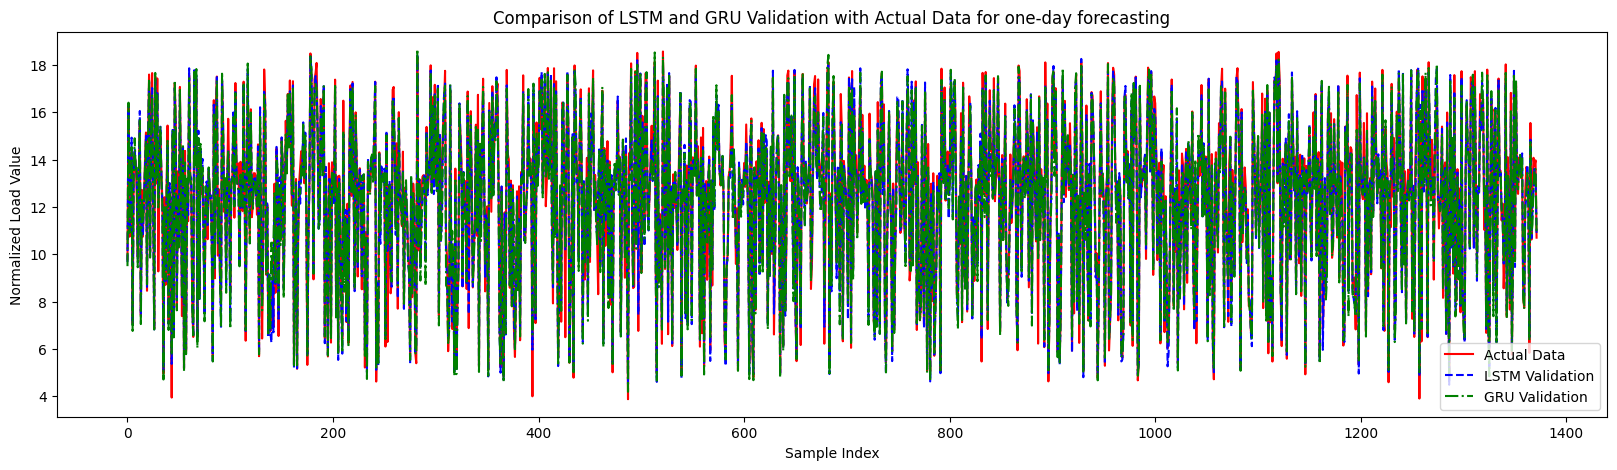

In [75]:
lstm_validation = model_LSTM.predict(X_val)
gru_validation = model_GRU.predict(X_val)
y_daily_val = np.sum(y_val.reshape(-1, 24), axis=1)
lstm_daily_val = np.sum(lstm_validation.reshape(-1, 24), axis=1)
gru_daily_val = np.sum(gru_validation.reshape(-1, 24), axis=1)

# Plotting
plt.figure(figsize=(20, 5))
plt.plot(y_daily_val, label='Actual Data', color='red', linestyle='-')
plt.plot(lstm_daily_val, label='LSTM Validation', color='blue', linestyle='--')
plt.plot(gru_daily_val, label='GRU Validation', color='green', linestyle='-.')
plt.title('Comparison of LSTM and GRU Validation with Actual Data for one-day forecasting')
plt.xlabel('Sample Index')
plt.ylabel('Normalized Load Value')
plt.legend()
plt.show()

### One Week Forecasting

In [ ]:
n_input_steps = 72
n_output_steps = 168
n_features = 23
X, y = create_sequences(filtered_data, n_input_steps, n_output_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM
model_LSTM = create_model_w('LSTM', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.001)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_LSTM.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=0, batch_size=32)

# GRU
model_GRU = create_model_w('GRU', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.001)
model_GRU.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_GRU.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=0, batch_size=32)

# Evaluate
X_val, y_val = X_train[int(X_train.shape[0]*0.8):], y_train[int(y_train.shape[0]*0.8):]
lstm_eval = model_LSTM.evaluate(X_val, y_val, verbose=0)
gru_eval = model_GRU.evaluate(X_val, y_val, verbose=0)
lstm_eval, gru_eval

In [76]:
n_input_steps = 168
n_output_steps = 168
n_features = 23
X, y = create_sequences(filtered_data, n_input_steps, n_output_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM
model_LSTM = create_model_w('LSTM', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.001)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_LSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# GRU
model_GRU = create_model_w('GRU', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.001)
model_GRU.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_GRU.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# Evaluate
X_val, y_val = X_train[int(X_train.shape[0]*0.8):], y_train[int(y_train.shape[0]*0.8):]
lstm_eval = model_LSTM.evaluate(X_val, y_val, verbose=0)
gru_eval = model_GRU.evaluate(X_val, y_val, verbose=0)
lstm_eval, gru_eval

(0.004689190071076155, 0.005157854408025742)

In [77]:
n_input_steps = 336
n_output_steps = 168
n_features = 23
X, y = create_sequences(filtered_data, n_input_steps, n_output_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM
model_LSTM = create_model_w('LSTM', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.001)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_LSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# GRU
model_GRU = create_model_w('GRU', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.001)
model_GRU.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_GRU.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# Evaluate
X_val, y_val = X_train[int(X_train.shape[0]*0.8):], y_train[int(y_train.shape[0]*0.8):]
lstm_eval = model_LSTM.evaluate(X_val, y_val, verbose=0)
gru_eval = model_GRU.evaluate(X_val, y_val, verbose=0)
lstm_eval, gru_eval

(0.00425253389403224, 0.004223233554512262)

In [79]:
n_input_steps = 672
n_output_steps = 168
n_features = 23
X, y = create_sequences(filtered_data, n_input_steps, n_output_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM
model_LSTM = create_model_w('LSTM', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.001)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_LSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# GRU
model_GRU = create_model_w('GRU', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.001)
model_GRU.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_GRU.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# Evaluate
X_val, y_val = X_train[int(X_train.shape[0]*0.8):], y_train[int(y_train.shape[0]*0.8):]
lstm_eval = model_LSTM.evaluate(X_val, y_val, verbose=0)
gru_eval = model_GRU.evaluate(X_val, y_val, verbose=0)
lstm_eval, gru_eval

(0.0041420371271669865, 0.0033944754395633936)

|n_steps| 168   | 336   | 672   |
|-------|-------|-------|-------|
| LSTM  |0.0685 |0.0652 |0.0644 |
|       |       |       |       |
|  GRU  |0.0718 |0.0650 |0.0583 |

* Increasing Sequence Length

Both models generally benefit from an increased sequence length up to a point, but the GRU model shows a more pronounced improvement as n_steps increases.
* Optimal Sequence Length

The optimal sequence length for forecasting one week of electricity load appears to be longer than one week of past data. Both models perform better when they have access to multiple weeks of data.
* Model Suitability

The GRU model might be more suitable for this particular task when dealing with long sequence lengths, as it outperforms the LSTM at 672 steps.


In [83]:
# LSTM
model_LSTM = create_model_w('LSTM', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_LSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# GRU
model_GRU = create_model_w('GRU', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_GRU.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_GRU.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# Evaluate
X_val, y_val = X_train[int(X_train.shape[0]*0.8):], y_train[int(y_train.shape[0]*0.8):]
lstm_eval = model_LSTM.evaluate(X_val, y_val, verbose=0)
gru_eval = model_GRU.evaluate(X_val, y_val, verbose=0)
lstm_eval, gru_eval

(0.0024096479173749685, 0.002021084539592266)

* Learning Rate Sensitivity: Both LSTM and GRU models are sensitive to the learning rate. The right learning rate can significantly improve model performance.
* Model Performance: At a higher learning rate of 0.01, the GRU model not only surpasses its performance at the lower learning rate but also outperforms the LSTM model. This indicates that GRU might be more responsive to a higher learning rate in this context.
* Balance in Learning Rate Selection: A higher learning rate can speed up training but may cause instability or overshooting. Conversely, a too-low learning rate might result in slow convergence or getting stuck in local minima.
* Experimentation is Key: These results highlight the importance of hyperparameter tuning, especially for learning rates. The optimal setting can vary depending on the model architecture and the specific task.

In [85]:
# LSTM
model_LSTM = create_model_w('LSTM', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=lr_schedule)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_LSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# GRU
model_GRU = create_model_w('GRU', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=lr_schedule)
model_GRU.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_GRU.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=32)

# Evaluate
X_val, y_val = X_train[int(X_train.shape[0]*0.8):], y_train[int(y_train.shape[0]*0.8):]
lstm_eval = model_LSTM.evaluate(X_val, y_val, verbose=0)
gru_eval = model_GRU.evaluate(X_val, y_val, verbose=0)
lstm_eval, gru_eval

(0.0030297718476504087, 0.0016035520238801837)

40/40 [==============================] - 2s 35ms/step


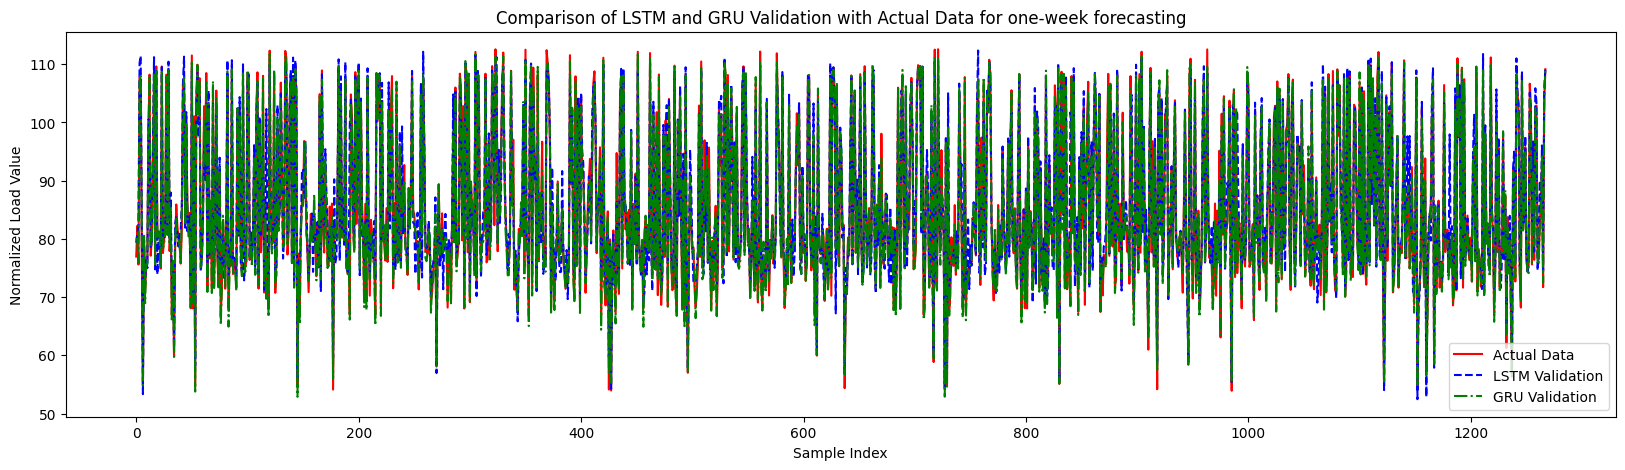

In [86]:
lstm_validation = model_LSTM.predict(X_val)
gru_validation = model_GRU.predict(X_val)

y_daily_val = np.sum(y_val.reshape(-1, 168), axis=1)
lstm_daily_val = np.sum(lstm_validation.reshape(-1, 168), axis=1)
gru_daily_val = np.sum(gru_validation.reshape(-1, 168), axis=1)
# Plotting
plt.figure(figsize=(20, 5))
plt.plot(y_daily_val, label='Actual Data', color='red', linestyle='-')
plt.plot(lstm_daily_val, label='LSTM Validation', color='blue', linestyle='--')
plt.plot(gru_daily_val, label='GRU Validation', color='green', linestyle='-.')
plt.title('Comparison of LSTM and GRU Validation with Actual Data for one-week forecasting')
plt.xlabel('Sample Index')
plt.ylabel('Normalized Load Value')
plt.legend()
plt.show()

## Implementation

For one hour forecasting, we set n_features = 3 ('Load', 'Temperature', 'HDL'), n_steps = 48 with learning rate = 0.01.


55/55 [==============================] - 1s 5ms/step


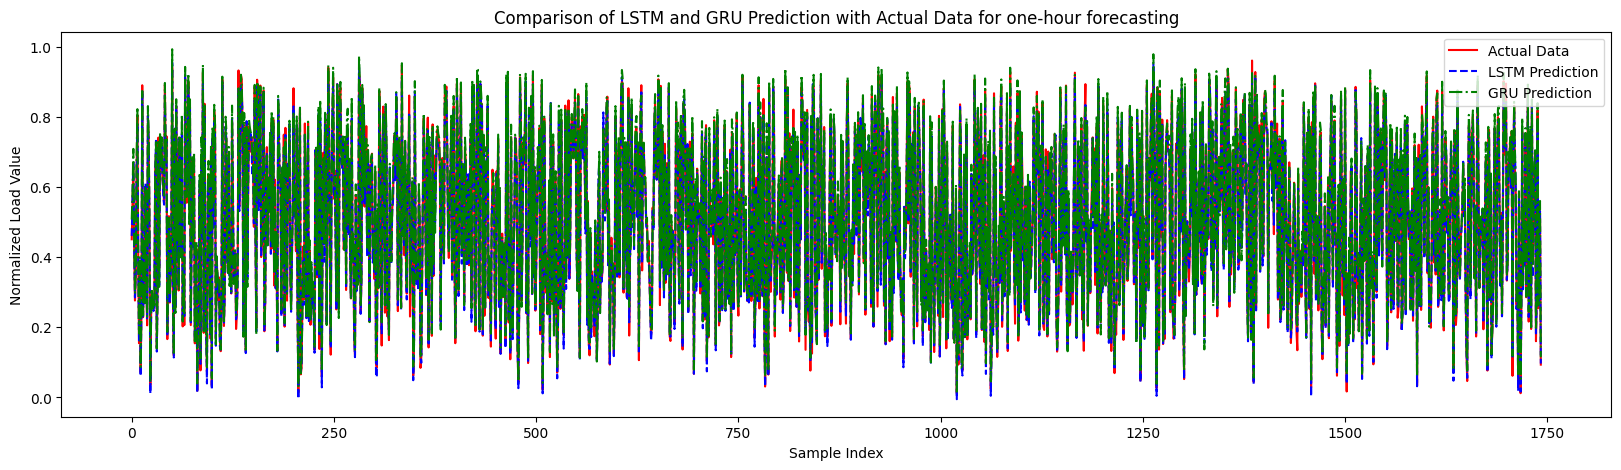

In [88]:
n_steps = 48
n_features = 3
X, y = create_dataset(filtered_data_3, n_steps)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM
model_LSTM = create_model_h('LSTM', input_shape = (n_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)
history_LSTM = model_LSTM.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=0, batch_size=32)

# GRU
model_GRU = create_model_h('GRU', input_shape = (n_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_GRU.compile(loss='mean_squared_error', optimizer=optimizer)
history_GRU = model_GRU.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=0, batch_size=32)

lstm_pre = model_LSTM.predict(X_test)
gru_pre = model_GRU.predict(X_test)
# Plotting
plt.figure(figsize=(20, 5))
plt.plot(y_test, label='Actual Data', color='red', linestyle='-')
plt.plot(lstm_pre, label='LSTM Prediction', color='blue', linestyle='--')
plt.plot(gru_pre, label='GRU Prediction', color='green', linestyle='-.')
plt.title('Comparison of LSTM and GRU Prediction with Actual Data for one-hour forecasting')
plt.xlabel('Sample Index')
plt.ylabel('Normalized Load Value')
plt.legend()
plt.show()

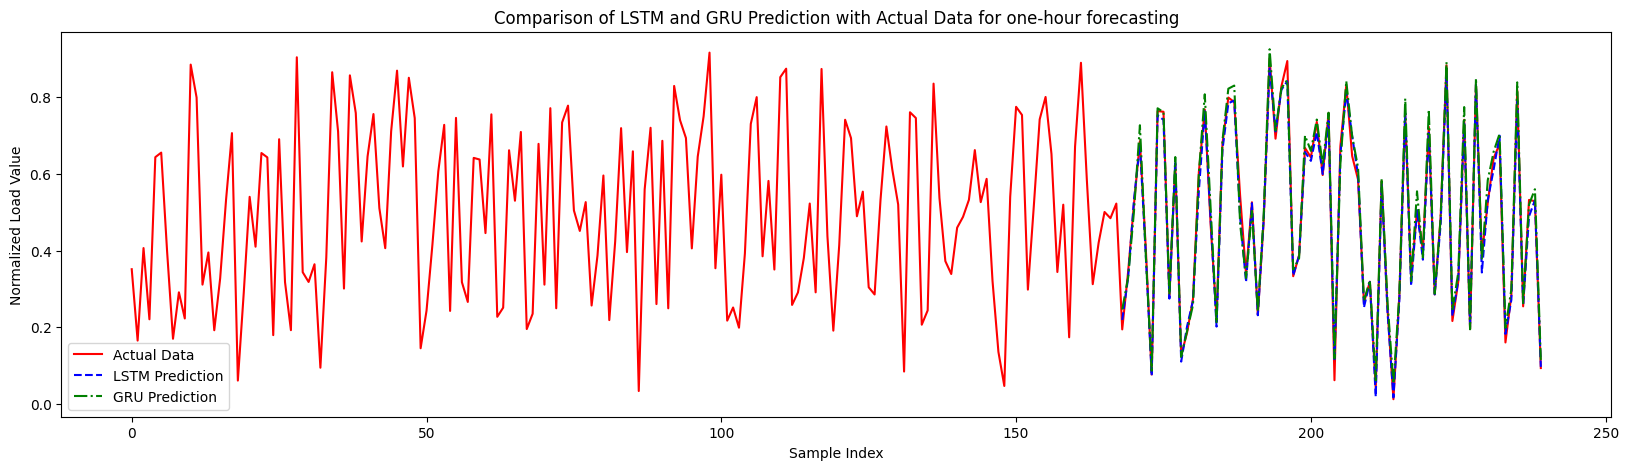

In [91]:
# Slicing the data
y_test_subset = y_test[-240:]
lstm_pre_subset = lstm_pre[-72:]
gru_pre_subset = gru_pre[-72:]

# Preparing indices to align the plots
index_y_test = range(len(y_test_subset))
index_lstm_pre = range(len(y_test_subset) - 72, len(y_test_subset))
index_gru_pre = range(len(y_test_subset) - 72, len(y_test_subset))

# Plotting
plt.figure(figsize=(20, 5))
plt.plot(index_y_test, y_test_subset, label='Actual Data', color='red', linestyle='-')
plt.plot(index_lstm_pre, lstm_pre_subset, label='LSTM Prediction', color='blue', linestyle='--')
plt.plot(index_gru_pre, gru_pre_subset, label='GRU Prediction', color='green', linestyle='-.')

plt.title('Comparison of LSTM and GRU Prediction with Actual Data for one-hour forecasting')
plt.xlabel('Sample Index')
plt.ylabel('Normalized Load Value')
plt.legend()
plt.show()

For one day forecasting, we set n_features = 23 ('Load', 'Temperature', 'HDL', 'Month', 'Week', 'holiday'), n_steps = 168 with learning rate = 0.001.



54/54 [==============================] - 1s 12ms/step


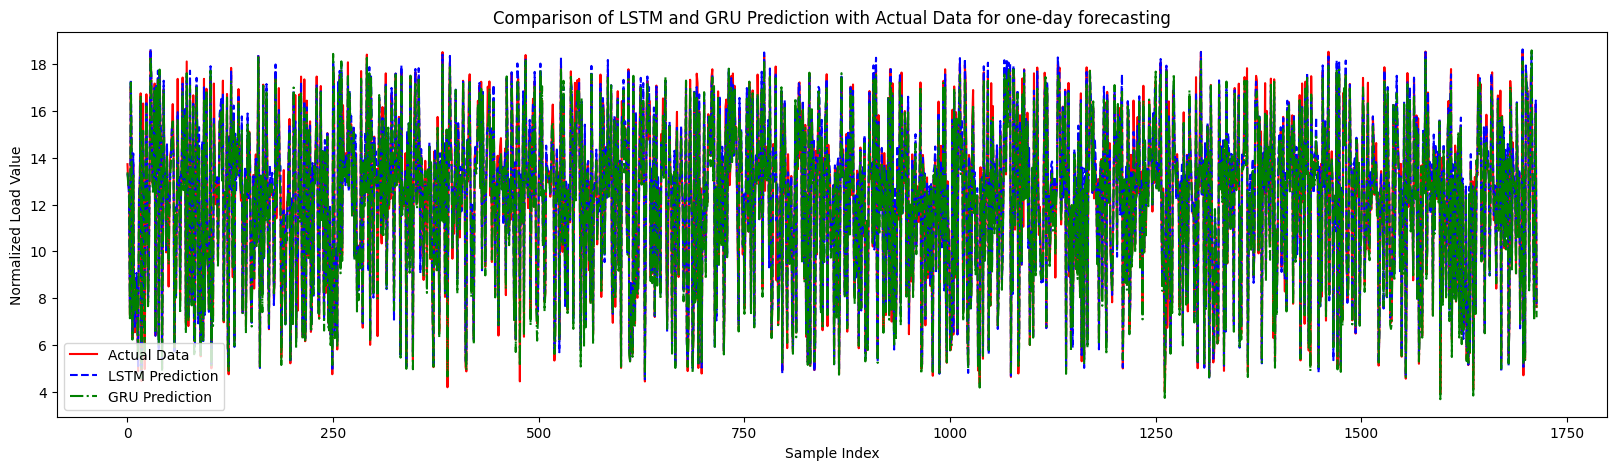

In [93]:
n_input_steps = 168
n_output_steps = 24
n_features = 23
X, y = create_sequences(filtered_data, n_input_steps, n_output_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM
model_LSTM = create_model_d('LSTM', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_LSTM.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=0, batch_size=32)

# GRU
model_GRU = create_model_d('GRU', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_GRU.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_GRU.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=0, batch_size=32)

lstm_pre = model_LSTM.predict(X_test)
gru_pre = model_GRU.predict(X_test)

y_daily = np.sum(y_test.reshape(-1, 24), axis=1)
lstm_daily_pre = np.sum(lstm_pre.reshape(-1, 24), axis=1)
gru_daily_pre = np.sum(gru_pre.reshape(-1, 24), axis=1)
# Plotting
plt.figure(figsize=(20, 5))
plt.plot(y_daily, label='Actual Data', color='red', linestyle='-')
plt.plot(lstm_daily_pre, label='LSTM Prediction', color='blue', linestyle='--')
plt.plot(gru_daily_pre, label='GRU Prediction', color='green', linestyle='-.')
plt.title('Comparison of LSTM and GRU Prediction with Actual Data for one-day forecasting')
plt.xlabel('Sample Index')
plt.ylabel('Normalized Load Value')
plt.legend()
plt.show()

For one week forecasting, we set n_features = 23 ('Load', 'Temperature', 'HDL', 'Month', 'Week', 'holiday'), n_steps = 336 with dynamitic learning rate.

50/50 [==============================] - 3s 49ms/step


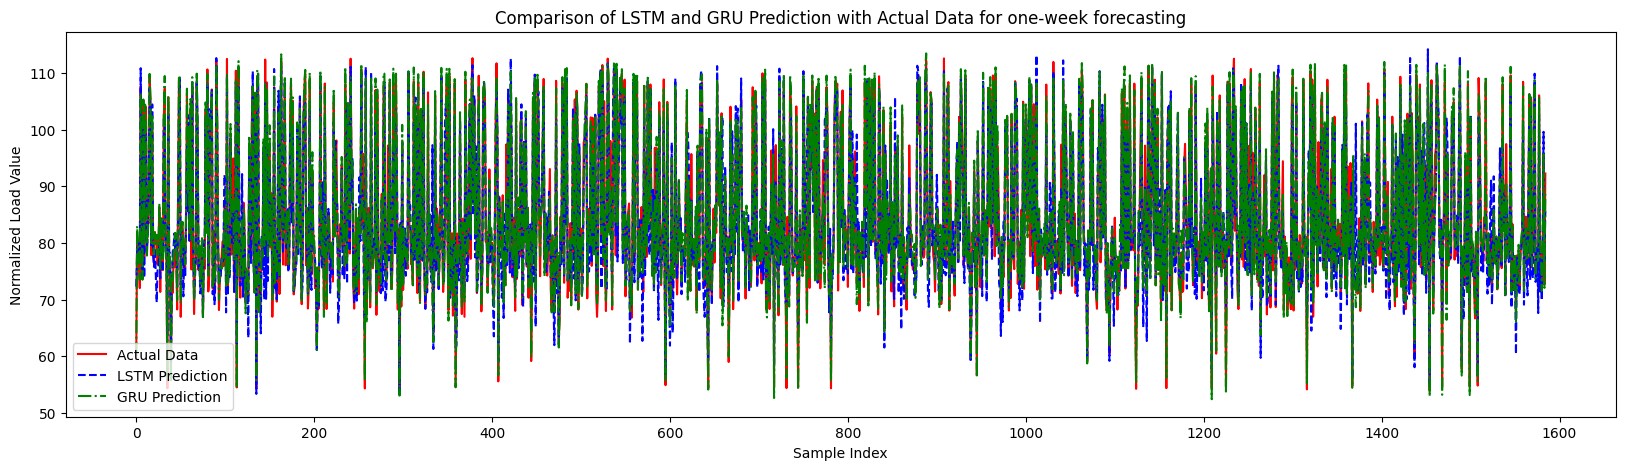

In [96]:
n_input_steps = 672
n_output_steps = 168
n_features = 23
X, y = create_sequences(filtered_data, n_input_steps, n_output_steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM
model_LSTM = create_model_w('LSTM', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=0.01)
model_LSTM.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_LSTM.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=0, batch_size=32)

# GRU
model_GRU = create_model_w('GRU', input_shape = (n_input_steps, n_features))
optimizer = Adam(learning_rate=lr_schedule)
model_GRU.compile(loss='mean_squared_error', optimizer=optimizer)
history = model_GRU.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=0, batch_size=32)

lstm_pre = model_LSTM.predict(X_test)
gru_pre = model_GRU.predict(X_test)

y_weekly = np.sum(y_test.reshape(-1, 168), axis=1)
lstm_weekly_pre = np.sum(lstm_pre.reshape(-1, 168), axis=1)
gru_weekly_pre = np.sum(gru_pre.reshape(-1, 168), axis=1)
# Plotting
plt.figure(figsize=(20, 5))
plt.plot(y_weekly, label='Actual Data', color='red', linestyle='-')
plt.plot(lstm_weekly_pre, label='LSTM Prediction', color='blue', linestyle='--')
plt.plot(gru_weekly_pre, label='GRU Prediction', color='green', linestyle='-.')
plt.title('Comparison of LSTM and GRU Prediction with Actual Data for one-week forecasting')
plt.xlabel('Sample Index')
plt.ylabel('Normalized Load Value')
plt.legend()
plt.show()

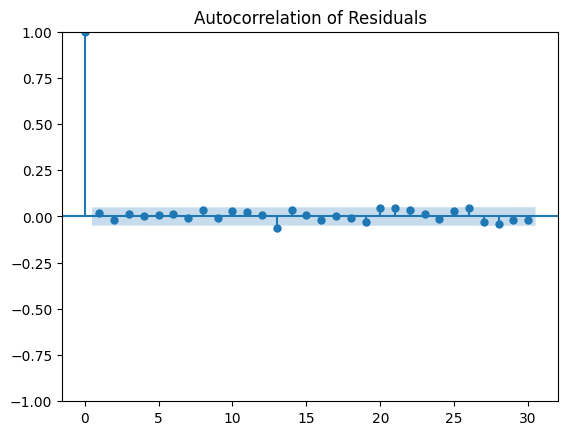

In [105]:
residuals = y_weekly - lstm_weekly_pre
plot_acf(residuals, lags=30)
plt.title('Autocorrelation of Residuals')
plt.show()

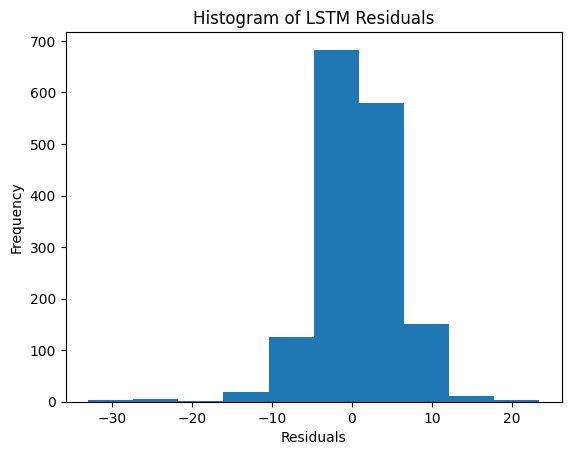

In [109]:
plt.hist(residuals, bins=10)
plt.title('Histogram of LSTM Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()